# Image Captioning

Gerando legendas para imagens reais

Model architecture: CNN encoder and RNN decoder. 

Show and Tell: A Neural Image Caption Generator (https://arxiv.org/abs/1411.4555 )


<img src="https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png" style="width:70%">

# *Data*

Relevant links
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

### What is COCO?
COCO [ https://cocodataset.org/#download ] is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:

- Object segmentation
- Recognition in context
- Superpixel stuff segmentation
- 330K images (>200K labeled)
- 1.5 million object instances
- 80 object categories
- 91 stuff categories
- 5 captions per image
- 250,000 people with keypoints


# Setup Google Drive

In [ ]:
import os
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Mounted at /content/gdrive
/content/gdrive/My Drive/colab/weights_10


# Import stuff and Download Data

In [ ]:
%env EXPERIMENTAL_TQDM=1
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

import sys
%tensorflow_version 1.x
sys.path.append("..")
import grading
import download_utils
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
download_utils.link_all_keras_resources()
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
import tqdm_utils
import utils_pytorch as utils_pytorch
download_utils.link_week_6_resources()

env: EXPERIMENTAL_TQDM=1
--2020-10-23 17:10:17--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-10-23 17:10:17 (61.1 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



# Extract image features

Usaremos ResNet Achitecture como CNN encoder. Nesse link fala um pouco sobre a resnet> (https://miro.medium.com/max/500/1*2ns4ota94je5gSVjrpFq3A.png). Extrairemos a última camada como image embedding;

<img src="https://miro.medium.com/max/500/1*2ns4ota94je5gSVjrpFq3A.png" style="width:70%">

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
IMG_SIZE = 299

In [ ]:
def initialize_model(model_name, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained).eval()

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained).eval()

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained).eval()

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained).eval()

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained).eval()

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained).eval()

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft.to('cuda')


#INITIALIZE MODELS TO EXTRACT FEATURES
resnet_model = initialize_model("resnet")
#alexnet_model = initialize_model("alexnet")
#vgg_model = initialize_model("vgg")
#squeezenet_model = initialize_model("squeezenet")
##inception_model = initialize_model("inception")




Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
import importlib
import utils_pytorch
importlib.reload(utils_pytorch)


# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
 
 

#sample_zip("gdrive/My Drive/train2014.zip", "gdrive/My Drive/train2014_sample.zip")
#sample_zip("gdrive/My Drive/val2014.zip", "gdrive/My Drive/val2014_sample.zip")



def process_feature_extraction(model,model_name):
  # extract train features
  train_img_embeds, train_img_fns = utils_pytorch.apply_model(
    "/content/gdrive/My Drive/train2014.zip", model, input_shape=(IMG_SIZE, IMG_SIZE))
  utils.save_pickle(train_img_embeds, "gdrive/My Drive/train_img_embeds_"+model_name+".pickle")
  utils.save_pickle(train_img_fns, "gdrive/My Drive/train_img_fns_"+model_name+".pickle")
 
  # extract validation features
  val_img_embeds, val_img_fns = utils_pytorch.apply_model(
      "/content/gdrive/My Drive/val2014.zip", model, input_shape=(IMG_SIZE, IMG_SIZE))
  utils.save_pickle(val_img_embeds, "gdrive/My Drive/val_img_embeds_"+model_name+".pickle")
  utils.save_pickle(val_img_fns, "gdrive/My Drive/val_img_fns_"+model_name+".pickle")


In [ ]:
# load prepared embeddings

model_name = "resnet"

train_img_embeds = utils.read_pickle("gdrive/My Drive/train_img_embeds_"+model_name+".pickle")
train_img_fns = utils.read_pickle("gdrive/My Drive/train_img_fns_"+model_name+".pickle")
val_img_embeds = utils.read_pickle("gdrive/My Drive/val_img_embeds_"+model_name+".pickle")
val_img_fns = utils.read_pickle("gdrive/My Drive/val_img_fns_"+model_name+".pickle")


In [ ]:
def process_img_embeddings(train_img_embeds1):
  aux = np.zeros((len(train_img_embeds1[0])*(len(train_img_embeds1)-1)+len(train_img_embeds1[-1]), 1000),dtype=float)

  index = 0
  for batch_index in np.arange(len(train_img_embeds1)):
    for image_index in np.arange(len(train_img_embeds1[batch_index])):
      image_embedding = train_img_embeds1[batch_index][image_index]
      aux[index] = np.array(image_embedding.cpu().numpy())
      index+=1
  return aux

train_img_embeds = process_img_embeddings(train_img_embeds)
val_img_embeds = process_img_embeddings(val_img_embeds)




In [ ]:
len(train_img_fns)

82612

In [ ]:
train_img_embeds.shape

(82612, 1000)

In [ ]:
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extraindo captions das imagens

In [ ]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82612 82612
40438 40438


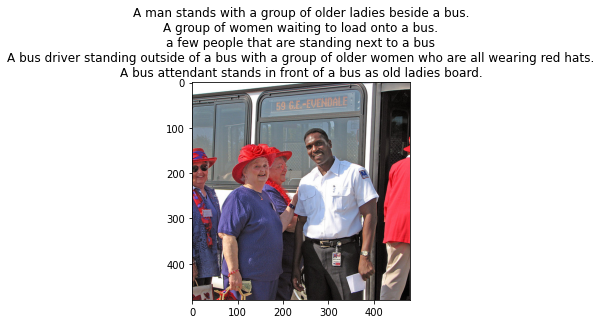

In [ ]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=150)

# Prepare captions for training

In [ ]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [ ]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = set()
    vocab_count = {}
    for array_of_captions in train_captions:
        for words in array_of_captions:
            for word in split_sentence(str(words)):
                if word in vocab_count.keys():
                    vocab_count[word]+=1
                else:
                    vocab_count[word] = 1
    for key,value in vocab_count.items():
        if value>=5:
            vocab.add(key)
    vocab.add(PAD)
    vocab.add(UNK)
    vocab.add(START)
    vocab.add(END)
    return {token: index for index, token in enumerate(sorted(vocab))}


# let's check our function for correct size and presence of a tabby cat
ex = [['A tabby cat sitting in front of a car.', 'A brown and black cat sitting on driveway next to a white car.',
       'A sleepy looking cat sitting in front of a white car.', 'A cat sits in front of a parked car.',
       'A cat sitting in front of a parked white car.']]
assert (len(generate_vocabulary(ex)) == 7 and 'cat' in generate_vocabulary(ex))


def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    vocab = generate_vocabulary(train_captions)
    ans = []
    
    for array_of_captions in captions:
        ans_aux = []
        for sentence in array_of_captions:
            ans_aux_sentence = []
            ans_aux_sentence.append(vocab[START])
            for word in split_sentence(sentence):
                if word in vocab.keys():
                     ans_aux_sentence.append(vocab[word])
                else:
                     ans_aux_sentence.append(vocab[UNK])
            ans_aux_sentence.append(vocab[END])
            ans_aux.append(ans_aux_sentence)
        ans.append(ans_aux)
    return ans

In [ ]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8759


In [ ]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [ ]:
train_captions_indexed

[[[2, 54, 4456, 2303, 6319, 3350, 7838, 54, 3103, 0],
  [2, 54, 6531, 5119, 8476, 249, 54, 5429, 8497, 0],
  [2, 54, 6493, 5429, 7571, 1123, 8042, 4281, 7895, 54, 638, 0],
  [2, 5112, 8357, 7838, 54, 2303, 6319, 7571, 1123, 54, 3104, 331, 0],
  [2, 2303, 5429, 4280, 709, 586, 8042, 7895, 5166, 5675, 0]],
 [[2, 54, 3480, 5119, 8745, 7286, 5017, 7895, 2537, 5214, 0],
  [2, 7825, 3993, 242, 3873, 5119, 5119, 8746, 2465, 0],
  [2, 8746, 249, 763, 6700, 7794, 6475, 8482, 3734, 0],
  [2, 8746, 7790, 330, 710, 5246, 249, 2465, 8476, 7909, 0],
  [2, 54, 5064, 5119, 8746, 2465, 8476, 4967, 5151, 269, 0]],
 [[2, 54, 7633, 1286, 6878, 3881, 3171, 5119, 54, 1226, 0],
  [2,
   54,
   1001,
   249,
   776,
   1286,
   6878,
   5147,
   2473,
   5017,
   7895,
   54,
   8558,
   1226,
   0],
  [2, 54, 6959, 4464, 1286, 6878, 3881, 3171, 5119, 54, 8558, 1226, 0],
  [2, 54, 1286, 6875, 3881, 3171, 5119, 54, 5379, 1226, 0],
  [2, 54, 1286, 6878, 3881, 3171, 5119, 54, 5379, 8558, 1226, 0]],
 [[2,
   54,


Nós vamos preencher as sentenças com PADDING, porém ignoraremos no cálculo do erro esses paddings;

In [ ]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len == None:    
        max_len =  max(map(len,batch_captions))   
    columns = min(max_len,  max(map(len,batch_captions)))
    ans = []
    matrix = np.full((len(batch_captions), columns),pad_idx)   
    line_number = 0
    for sentence in batch_captions:    
        tam_sentence = len(sentence)
        line = np.array(sentence)
        if tam_sentence > columns:  
            line = np.delete(line, np.arange(columns,tam_sentence))
        if tam_sentence < columns:
            a = np.zeros(columns-tam_sentence)
            a.fill(pad_idx)
            line = np.append(line,a)
        matrix[line_number] = line
        line_number+=1
   
    return matrix

# Training

## Define architecture

Como nosso problema é gerar legendas de imagens, o gerador de texto RNN deve ser condicionado à imagem. A ideia é usar recursos de imagem como um estado inicial para RNN em vez de zeros.


Referências (http://cs.stanford.edu/people/karpathy/):

In [ ]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [ ]:
from keras_utils import reset_tf_session

s = reset_tf_session()
tf.set_random_seed(42)

Using TensorFlow backend.


### Decoder Helper:
<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/flatten_help.jpg?raw=1" style="width:80%">

In [ ]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,(-1,LSTM_UNITS))

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    #flat_loss_mask = flat_ground_truth.map(lambda id: 0.0 if id == pad_idx else 1.0, flat_ground_truth)
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)
    
    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

In [ ]:
# look at the shapes, can help with debug
def print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s):
    tensors_to_test = [
        decoder.h0,
        decoder.word_embeds,
        decoder.flat_hidden_states,
        decoder.flat_token_logits,
        decoder.flat_ground_truth,
        decoder.flat_loss_mask,
        decoder.loss
    ]
    all_shapes = []
    for t in tensors_to_test:
        _ = s.run(t, feed_dict=grading_utils.get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
        print("{}: {}".format(t.name, _.shape))
        
print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s)

dense_1/Elu:0: (32, 300)
embedding/embedding_lookup/Identity_1:0: (32, 19, 100)
Reshape:0: (608, 300)
dense_3/BiasAdd:0: (608, 8759)
Reshape_1:0: (608,)
NotEqual:0: (608,)
Mean:0: ()


## Training loop


In [ ]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [ ]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
import random
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    
    random_positions = np.empty(batch_size)
    random_positions = list(map(lambda x: random.randint(0,images_embeddings.shape[0]-1) , random_positions))
    batch_image_embeddings = images_embeddings[random_positions,:]
    indexed_captions_batch = indexed_captions[random_positions]
    batch_captions_matrix = [img[np.random.randint(5)] for img in indexed_captions_batch]

    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix,pad_idx,max_len)
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [ ]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [ ]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Can't get public url, retrying...
Open https://9c2b98fe9ff3.ngrok.io to access your 6006 port


In [ ]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [ ]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.469326998710632, val loss: 3.9129019665718077



Epoch: 1, train loss: 3.5825742197036745, val loss: 3.365224039554596



Epoch: 2, train loss: 3.198197266101837, val loss: 3.1018292021751406



Epoch: 3, train loss: 3.027827889442444, val loss: 3.022269158363342



Epoch: 4, train loss: 2.9133643238544464, val loss: 2.9283326482772827



Epoch: 5, train loss: 2.841806789159775, val loss: 2.863195140361786
Instructions for updating:
Use standard file APIs to delete files with this prefix.



Epoch: 6, train loss: 2.787902819156647, val loss: 2.8439946079254153



Epoch: 7, train loss: 2.7493949880599975, val loss: 2.791011321544647



Epoch: 8, train loss: 2.714367785692215, val loss: 2.752951502799988



Epoch: 9, train loss: 2.68327855181694, val loss: 2.736739957332611



Epoch: 10, train loss: 2.6575953063964843, val loss: 2.734417424201965



Epoch: 11, train loss: 2.6356920347213744, val loss: 2.737653832435608
Finished!


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.585308
Accuracy: 0.48582995951417
Example 0
Predicted: a bathroom is a cat in a of mirror mirror #END# from the window #END# #END# #END# #END# #END#
Truth: a person holding a camera in front a bathroom mirror hanging over a sink #END# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a street stop sign sitting on a side of a street #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a red stop sign sitting on the side of a street #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a vase with a of a table of a table #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a vase and statue on the top of a desk #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [ ]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab/weights'

# Applicando o modelo

Funcionamento- 
- Pegando uma imagem como input e transformando em um embbed aplicando o modelo
- Input esse embbeding no LSTM
- Predizero próximo token e usando esse próximo token como input da próxima iteração
- Iterar até encontrar o token END;

In [ ]:
def transform_pipeline(img):
    return transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(img)

In [ ]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    img_embeddings = []
    img = transform_pipeline(image)
    batch_imgs = [img]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    batch_imgs =  torch.from_numpy(np.stack(batch_imgs, axis=0)).to(device)
    with torch.no_grad():
          output = resnet_model(batch_imgs).to(device)
    img_embeds = torch.nn.functional.softmax(output, dim=1)
    img_embeddings.append(img_embeds)
    img_embeds = process_img_embeddings(img_embeddings)
     # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

    # condition lstm on the image
    s.run(init_lstm)
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(one_step, 
                                {current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a herd of cows standing on top of a lush green field


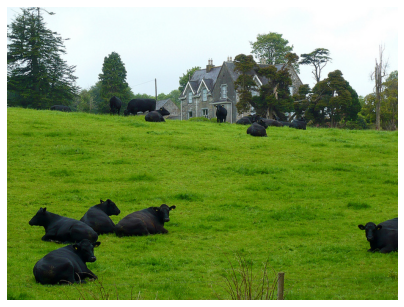

In [ ]:
# look at validation prediction example
import io
from PIL import Image

def apply_model_to_image_raw_bytes(raw):
    fh = io.BytesIO(raw)
    img = Image.open(fh)    
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=150)

a large passenger jet sitting on top of a runway


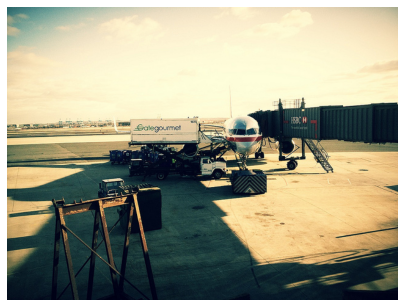

a woman is holding a cell phone in a park


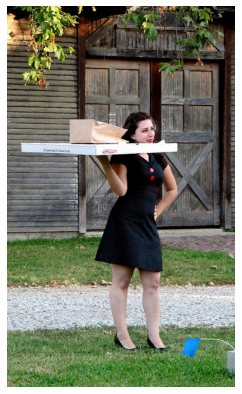

a vase with flowers sitting on top of a table


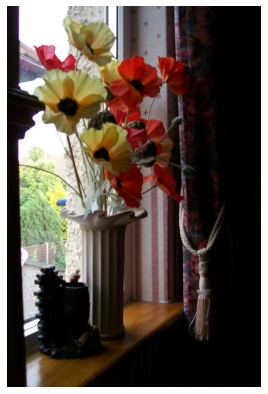

a bed with a bed and a lamp


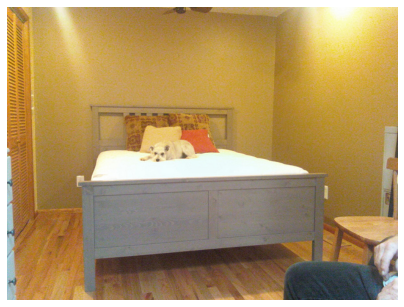

a cake with a knife and a knife


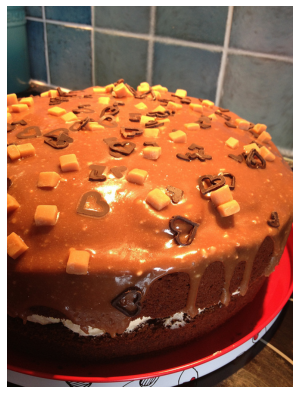

a pizza with cheese and cheese on a plate


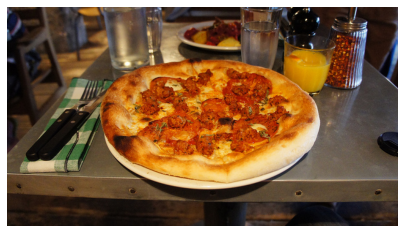

a cat is laying on a bed with a cat


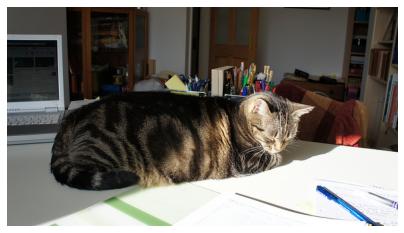

a man is sitting on a bench with a dog


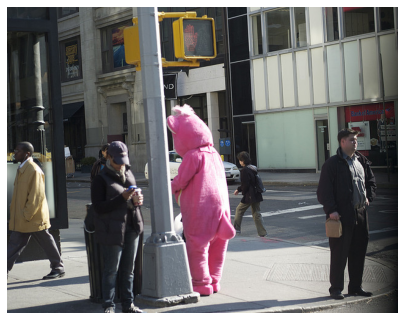

a man riding a motorcycle on a street


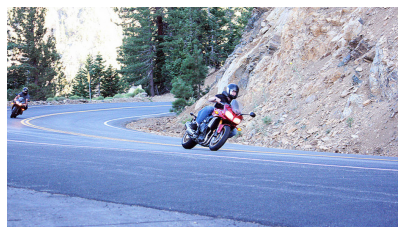

a beach with a beach and a beach


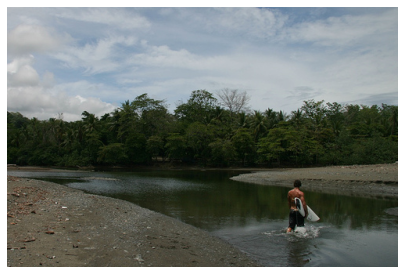

In [ ]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

a dog is laying on a bed with a dog


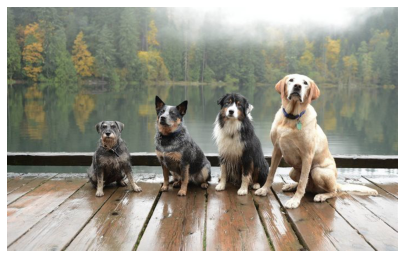

In [ ]:
apply_model_to_image_raw_bytes(open("thumb2-lake-dogs-fog-dog-nature.jpg", "rb").read())

In [ ]:
index=0
while(index<=15):
  time.sleep(2*60)
  print(index)
  index=index+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
